In [1]:
import os
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

In [2]:
sys.path.append("../../src/.")
from plotting_functions import plot_dendrogram_clusters

In [3]:
DIR = "../../data/"
SUBWAYUS = "Subway USA/subway_usa_"

In [4]:
train_df = pd.read_csv(DIR + SUBWAYUS + "processed_train.csv", index_col="store")
test_df = pd.read_csv(DIR + SUBWAYUS + "processed_test.csv", index_col="store")

In [5]:
def agg_inrix(df):
    inrix_columns = []
    for col in df.columns.tolist():
        if 'inrix_' in col:
            inrix_columns.append(col)
    df['inrix_total_ta'] = df[inrix_columns].sum(axis=1)
    df.drop(columns=inrix_columns, inplace=True)

agg_inrix(train_df)
agg_inrix(test_df)

In [6]:
result_df = pd.DataFrame([], index=train_df.index)

## PCA

### Test for Mininum Components to Capture 90% Variance

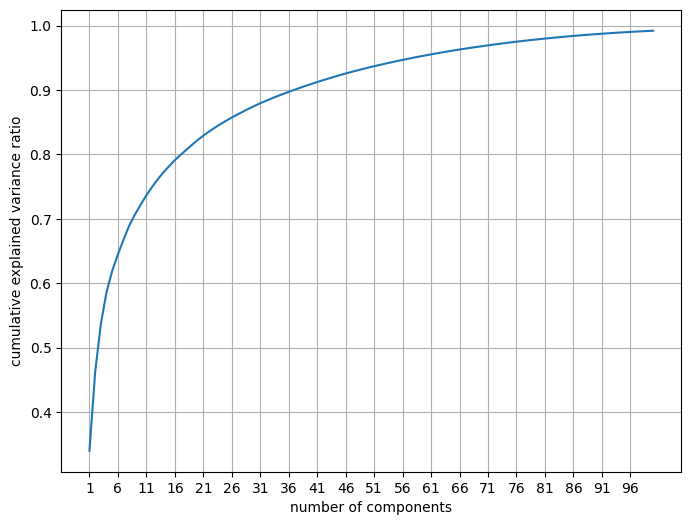

37

In [7]:
from plotting_functions import pca_100_plot


pca_100_plot(train_df)

### PCA model (90% Variance) - Layer 1

In [8]:
pca = PCA(n_components=37, whiten=True, random_state=42)
pca.fit(train_df)

PCA(n_components=37, random_state=42, whiten=True)

In [9]:
transformed_features = pd.DataFrame(
    abs(pca.components_), 
    columns=train_df.columns.tolist(), 
    index=pca.get_feature_names_out(train_df.columns.tolist()))
transformed_features.head()

,boomer_p_ta,dmm_count_5mi,nces_private_schools_5mi,centerxy_gla_effective_3mi,places_of_worship_5mi,dmm_count_1mi,dtpop_children_at_home_p_ta,emp_healthcare_social_assistance_p_ta,ipeds_postsecondary_schools_2mi,military_installations_5mi,...,com0508_p_ta,popcy_ta,dmm_gla_5mi,spend_dinner_ta,ipeds_postsecondary_schools_5mi,dmm_gla_1mi,crime_total_index_ta,market_size,store_density,inrix_total_ta
pca0,0.021305,0.057826,0.041270,0.057453,0.036262,0.032721,0.000760,0.019077,0.022518,0.011446,...,0.025619,0.055719,0.058187,0.051328,0.032421,0.032151,0.025329,0.111924,0.074301,0.912908
pca1,0.053457,0.097401,0.120601,0.040778,0.113805,0.032758,0.027885,0.035279,0.081044,0.050956,...,0.035114,0.109632,0.084044,0.106910,0.103214,0.023472,0.059795,0.109998,0.149006,0.357558
pca2,0.083890,0.041173,0.019877,0.025801,0.004532,0.015788,0.033292,0.015432,0.009222,0.016104,...,0.010033,0.020448,0.041346,0.039450,0.004873,0.013890,0.103127,0.188676,0.003885,0.120919
pca3,0.088180,0.009823,0.008938,0.003004,0.041095,0.032619,0.212438,0.087305,0.032997,0.050292,...,0.039202,0.088524,0.003168,0.080967,0.006677,0.020528,0.026534,0.173587,0.000039,0.064259
pca4,0.036616,0.008626,0.049077,0.043025,0.063972,0.020709,0.046262,0.019106,0.030816,0.026858,...,0.028731,0.008348,0.016698,0.021647,0.036098,0.018700,0.039078,0.075026,0.031141,0.041392


#### Filter and Count Important Features (of heavy weights)

Filter the values in the PCA component matrix, and count the occurrence of the features in the filtered matrix.

In [10]:
W = abs(pca.components_)
features = transformed_features.columns
long_results = []
for i in range(W.shape[0]):
    array = W[i]
    heavy_idx = np.where(array > 0.15)
    long_results += list(features[heavy_idx])

In [11]:
count = pd.Series(long_results).value_counts()
pca_features = count.index.tolist()
count

market_size                        12
military_installations_1mi         10
emp_transportation_storage_p_ta     9
gq_other_p_ta                       8
emp_publicadmin_p_ta                8
                                   ..
hh_type_fam_p_ta                    1
age85pl_p_ta                        1
hhinc30lt_p_ta                      1
hh_inc_gt_75k_p_ta                  1
places_of_worship_1mi               1
Name: count, Length: 120, dtype: int64

In [12]:
pca_feature_weight = pd.Series(np.sum(W, axis=0), index=transformed_features.columns)
pca_feature_weight.sort_values(ascending=False, inplace=True)
pca_feature_weight = pca_feature_weight.filter(items = pca_features, axis=0)
pca_feature_weight

market_size                        4.254747
military_installations_1mi         3.991399
emp_transportation_storage_p_ta    3.195740
gq_other_p_ta                      3.514649
emp_publicadmin_p_ta               3.396797
                                     ...   
hh_type_fam_p_ta                   1.645935
age85pl_p_ta                       1.932748
hhinc30lt_p_ta                     1.211498
hh_inc_gt_75k_p_ta                 0.944130
places_of_worship_1mi              1.767362
Length: 120, dtype: float64

In [13]:
important_features = pca_feature_weight.sort_values(ascending=False)[:40].index.tolist()

In [14]:
reduced_train = train_df[pca_features]
reduced_test = test_df[pca_features]
reduced_train

,market_size,military_installations_1mi,emp_transportation_storage_p_ta,gq_other_p_ta,emp_publicadmin_p_ta,emp_wholesale_trade_p_ta,emp_mining_p_ta,transitstop_nearest_dist,emp_arts_entertainment_p_ta,hh_type_male_child_p_ta,...,hh_expected_pers_ta,hh_type_1pers_p_ta,dtpop_unemployed_p_ta,hrsa_number_of_certified_beds_2mi,hrsa_hospitals_3mi,hh_type_fam_p_ta,age85pl_p_ta,hhinc30lt_p_ta,hh_inc_gt_75k_p_ta,places_of_worship_1mi
store,,,,,,,,,,,,,,,,,,,,,
5386700,4.0,-0.082631,1.538831,-0.874510,-0.270970,0.321934,-0.329934,0.173092,0.455597,-0.703362,...,-0.921958,-0.921958,-0.588669,-0.352700,-0.633117,0.848228,-0.344824,-0.518210,0.277339,-0.304795
2230200,0.0,-0.082631,-0.688641,2.510505,0.138317,-0.989126,-0.329934,-0.482872,0.495531,0.672875,...,-1.402529,-1.402529,0.353116,-0.352700,-0.633117,1.350859,-1.126964,-1.484616,1.680984,-0.262357
4931100,4.0,-0.082631,-0.596695,2.510505,2.172304,-0.243178,-0.329934,-0.484493,0.341498,1.120763,...,-1.493760,-1.493760,1.871505,-0.352700,-0.633117,1.102466,-0.899252,-0.178548,0.035529,-0.304795
2495200,1.0,-0.082631,-0.380177,-0.728955,-0.854554,0.175005,-0.329934,-0.431710,-0.228996,-1.322261,...,-0.447812,-0.447812,-1.194103,-0.352700,-0.633117,0.616395,1.219455,-1.140748,1.409126,-0.219918
2305300,3.0,-0.082631,0.088453,0.470356,-0.246070,-0.028435,-0.329934,-0.457116,0.090480,1.527934,...,-0.433678,-0.433678,1.439052,-0.268937,-0.242392,0.210199,-0.097312,-0.516107,0.018359,0.416662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401900,0.0,-0.082631,-0.166624,0.425674,-0.401693,-0.683966,-0.329934,-0.472782,-0.263226,0.615871,...,-0.162554,-0.162554,0.420386,-0.160744,-0.242392,0.087463,-0.364625,-0.652813,0.575667,0.162030
5048900,0.0,-0.082631,1.488409,1.285130,-0.459273,1.406950,-0.170505,-0.463896,-0.246111,-1.094245,...,-0.210097,-0.210097,-0.204267,-0.352700,-0.633117,0.193639,-0.463630,-1.066085,1.220257,-0.177479
1024900,5.0,-0.082631,0.135909,-0.415841,0.097856,-0.446619,-0.329934,0.362274,0.033431,0.778740,...,0.406678,0.406678,-0.752040,0.107993,-0.242392,0.003692,0.031395,0.771033,-0.763590,0.416662


In [15]:
def corr_pair(target_corr, corr_threshold=0.6):
    np.fill_diagonal(target_corr.values, 0)
    sorted_pair = target_corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
    return sorted_pair[sorted_pair > corr_threshold]

correlated_pairs = corr_pair(reduced_train.corr())

In [16]:
correlated_pairs[:20:2]

hh_expected_pers_ta                 hh_type_1pers_p_ta             1.000000
hh_inc_lt_75k_p_ta                  hh_inc_gt_75k_p_ta             1.000000
occ_military_p_ta                   emp_military_ta                1.000000
popgrpy_ta                          pop5y_cagr_ta                  0.999143
                                    hhgrpycy_ta                    0.996633
dtpop_students_post_secondary_p_ta  dtpop_students_p_ta            0.996588
hhgrfypy_ta                         popgrfy_ta                     0.996356
hhgrpycy_ta                         pop5y_cagr_ta                  0.996161
dtpop_students_prek_8th_p_ta        dtpop_children_at_home_p_ta    0.991793
disposable_inc_avg_ta               hhinc100pl_p_ta                0.989908
dtype: float64

In [17]:
def corr_pair_drop(feature_pairs, corr_with_target):
    selected, discarded = [], []
    for f1, f2 in feature_pairs:
        if abs(corr_with_target[f1]) < abs(corr_with_target[f2]):
            selected.append(f2)
            discarded.append(f1)
        else:
            selected.append(f1)
            discarded.append(f2)
    final_discarded = set(discarded) - set(selected) 
    return list(final_discarded)

In [18]:
corr_drop_list = corr_pair_drop(correlated_pairs.index, pca_feature_weight)

In [19]:
important_features = list(set(important_features) - set(corr_drop_list))

In [20]:
reduced_train.drop(columns=corr_drop_list, inplace=True)
reduced_test.drop(columns=corr_drop_list, inplace=True)

/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_84673/1625573170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train.drop(columns=corr_drop_list, inplace=True)
/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_84673/1625573170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test.drop(columns=corr_drop_list, inplace=True)


In [21]:
correlated_pairs = corr_pair(reduced_train.corr())
correlated_pairs[:20:2]

hh_type_1pers_p_ta            hh_expected_pers_ta            1.000000
popgrpy_ta                    pop5y_cagr_ta                  0.999143
                              hhgrpycy_ta                    0.996633
pop5y_cagr_ta                 hhgrpycy_ta                    0.996161
dtpop_students_prek_8th_p_ta  dtpop_children_at_home_p_ta    0.991793
disposable_inc_avg_ta         hhinc100pl_p_ta                0.989908
                              medhhinc_ta                    0.984498
medhhinc_ta                   hhinc100pl_p_ta                0.979840
hhinc150pl_p_ta               avghhinc_ta                    0.978147
disposable_inc_avg_ta         hhinc150pl_p_ta                0.975705
dtype: float64

### PCA model (90% Variance) - Layer 2

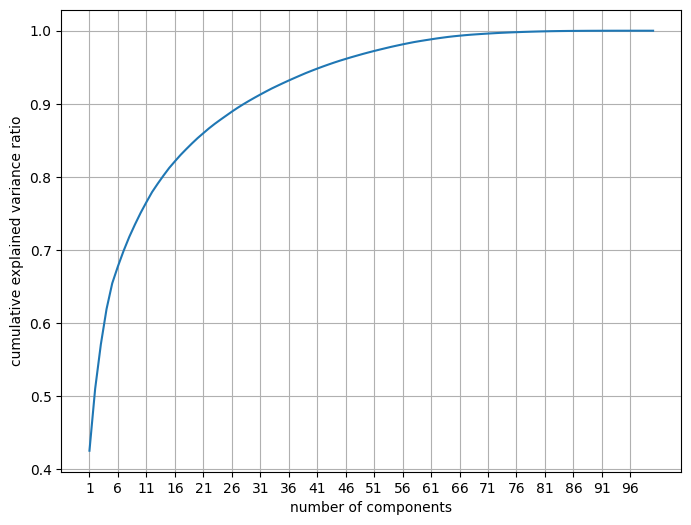

29

In [22]:
pca_100_plot(reduced_train)

In [23]:
pca_2 = PCA(n_components=29, whiten=True, random_state=42)
pca_2.fit(reduced_train)

PCA(n_components=29, random_state=42, whiten=True)

In [24]:
transformed_features = pd.DataFrame(
    abs(pca_2.components_), 
    columns=reduced_train.columns.tolist(), 
    index=pca_2.get_feature_names_out(reduced_train.columns.tolist()))
transformed_features.head()

,market_size,military_installations_1mi,emp_transportation_storage_p_ta,gq_other_p_ta,emp_publicadmin_p_ta,emp_wholesale_trade_p_ta,emp_mining_p_ta,transitstop_nearest_dist,emp_arts_entertainment_p_ta,hh_type_male_child_p_ta,...,genz_p_ta,osm_nearest_exit_dist,dtpop_students_p_ta,emp_p_ta,hh_expected_pers_ta,hh_type_1pers_p_ta,dtpop_unemployed_p_ta,hrsa_number_of_certified_beds_2mi,hh_type_fam_p_ta,hhinc30lt_p_ta
pca0,0.100593,0.003201,0.007310,0.014285,0.024967,0.000304,0.006639,0.023675,0.005293,0.009715,...,0.010677,0.027238,0.004067,0.019374,0.002067,0.002067,0.005356,0.013615,0.002200,0.019879
pca1,0.218144,0.006964,0.009457,0.041108,0.065864,0.010308,0.019924,0.080706,0.060569,0.069708,...,0.030368,0.040792,0.030489,0.012702,0.096098,0.096098,0.021348,0.026738,0.084026,0.228051
pca2,0.119415,0.071006,0.064529,0.005501,0.018672,0.062304,0.023514,0.080435,0.004645,0.064923,...,0.031999,0.087885,0.031833,0.182333,0.203307,0.203307,0.070789,0.150464,0.206732,0.011911
pca3,0.279788,0.016034,0.018994,0.065509,0.022810,0.056429,0.032781,0.049340,0.082487,0.091191,...,0.037540,0.175954,0.010110,0.086532,0.126966,0.126966,0.120247,0.001938,0.111573,0.016242
pca4,0.249214,0.026570,0.039128,0.047190,0.014096,0.006175,0.024230,0.009902,0.038280,0.030243,...,0.004591,0.068377,0.007634,0.005289,0.000074,0.000074,0.146332,0.098752,0.016869,0.015852


#### Filter and Count Important Features (of heavy weights)

Filter the values in the PCA component matrix, and count the occurrence of the features in the filtered matrix.

In [25]:
W = abs(pca_2.components_)
features = transformed_features.columns
long_results = []
for i in range(W.shape[0]):
    array = W[i]
    heavy_idx = np.where(array > 0.15)
    long_results += list(features[heavy_idx])

In [26]:
count = pd.Series(long_results).value_counts()
count

market_size                                  12
emp_mining_p_ta                              10
emp_arts_entertainment_p_ta                   9
transitstop_nearest_dist                      9
emp_publicadmin_p_ta                          8
                                             ..
dtpop_students_9th_12th_p_ta                  1
hh_expected_vehicle_ta                        1
hh_expected_pers_ta                           1
hh_type_1pers_p_ta                            1
nces_private_schools_total_enrollment_1mi     1
Name: count, Length: 96, dtype: int64

In [27]:
pca_2_features = count.index.tolist()

In [28]:
pca_2_feature_weight = pd.Series(np.sum(W, axis=0), index=transformed_features.columns)
pca_2_feature_weight.sort_values(ascending=False, inplace=True)
pca_2_feature_weight = pca_feature_weight.filter(items=pca_2_features, axis=0)
pca_2_feature_weight

market_size                                  4.254747
emp_mining_p_ta                              3.865497
emp_arts_entertainment_p_ta                  3.872087
transitstop_nearest_dist                     3.363647
emp_publicadmin_p_ta                         3.396797
                                               ...   
dtpop_students_9th_12th_p_ta                 1.746638
hh_expected_vehicle_ta                       1.780610
hh_expected_pers_ta                          1.368249
hh_type_1pers_p_ta                           1.368249
nces_private_schools_total_enrollment_1mi    1.651511
Length: 96, dtype: float64

In [29]:
pca_2_feature_weight = pca_2_feature_weight.sort_values(ascending=False)
important_features_2 = pca_2_feature_weight[:40].index.tolist()

In [30]:
important_features = list(set(important_features + important_features_2))

In [31]:
reduced_train = reduced_train[important_features]
reduced_test = reduced_test[important_features]
reduced_train

,transitstop_nearest_dist,emp_healthcare_social_assistance_p_ta,emp_realestate_rentlease_p_ta,nces_private_schools_nearest_dist,dtpop_homemakers_p_ta,hispanic_p_ta,com0002_p_ta,emp_finance_insurance_p_ta,market_size,military_installations_1mi,...,emp_transportation_storage_p_ta,asian_p_ta,osm_highway_exits_count_2mi,places_of_worship_2mi,genx_p_ta,hrsa_number_of_certified_beds_1mi,emp_other_p_ta,hrsa_hospitals_1mi,emp_wholesale_trade_p_ta,emp_retail_trade_p_ta
store,,,,,,,,,,,,,,,,,,,,,
5386700,0.173092,-1.576735,-0.808494,-0.297931,-0.595764,-0.535172,-0.745366,-1.268128,4.0,-0.082631,...,1.538831,-0.517596,0.097112,-0.424219,0.426720,-0.254175,-0.312266,-0.399250,0.321934,0.874682
2230200,-0.482872,0.493764,-0.126730,-0.336925,0.173287,0.402992,-0.635472,-0.207401,0.0,-0.082631,...,-0.688641,0.505259,-0.672945,-0.067795,0.539867,-0.254175,0.982317,-0.399250,-0.989126,-0.461127
4931100,-0.484493,-1.388615,2.481412,0.107431,2.325595,0.783947,-0.551156,-1.367707,4.0,-0.082631,...,-0.596695,0.307770,0.097112,-0.314550,0.838901,-0.254175,-1.019206,-0.399250,-0.243178,-0.845072
2495200,-0.431710,0.322104,-0.642016,-0.444643,-1.313200,-0.721585,-0.499998,0.831679,1.0,-0.082631,...,-0.380177,0.497087,-0.672945,-0.287133,-1.674597,-0.254175,-0.489001,-0.399250,0.175005,0.322761
2305300,-0.457116,0.432625,0.079384,-0.345034,-0.234465,-0.253773,0.751473,-0.177094,3.0,-0.082631,...,0.088453,-0.576161,-0.480430,-0.150047,0.394392,-0.072057,-0.365287,0.846326,-0.028435,0.458742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401900,-0.472782,1.916424,-0.134658,-0.333949,-0.084784,-0.137455,-0.517998,0.459342,0.0,-0.082631,...,-0.166624,1.212132,0.193369,0.507966,0.164055,-0.254175,-0.475746,-0.399250,-0.683966,-0.179167
5048900,-0.463896,0.070493,-0.102948,-0.432464,-1.012118,-0.207551,0.167895,-0.268014,0.0,-0.082631,...,1.488409,3.343646,0.963427,-0.012961,1.493542,-0.254175,-0.939676,-0.399250,1.406950,0.264769
1024900,0.362274,-0.464474,-0.824349,-0.248694,-0.079623,-0.682474,1.584208,-0.739929,5.0,-0.082631,...,0.135909,-0.569351,-0.672945,-0.081504,-0.510791,0.747474,-0.449236,0.846326,-0.446619,-0.561112


In [32]:
def corr_pair(target_corr, corr_threshold=0.6):
    np.fill_diagonal(target_corr.values, 0)
    sorted_pair = target_corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
    return sorted_pair[sorted_pair > corr_threshold]

correlated_pairs = corr_pair(reduced_train.corr())

In [33]:
correlated_pairs[:20:2]

dmm_gla_1mi                        dmm_count_1mi                        0.884128
military_installations_5mi         military_installations_3mi           0.859848
centerxy_gla_effective_1mi         dmm_gla_1mi                          0.769487
hrsa_hospitals_1mi                 hrsa_number_of_certified_beds_1mi    0.769365
osm_highway_exits_count_2mi        osm_highway_exits_count_1mi          0.764676
centerxy_gla_effective_1mi         dmm_count_1mi                        0.729324
com0508_p_ta                       com12pl_p_ta                         0.684701
nces_private_schools_nearest_dist  ipeds_postsecondary_nearest_dist     0.662017
nces_public_schools_1mi            places_of_worship_2mi                0.639073
dtype: float64

In [34]:
print(pca_feature_weight['military_installations_5mi'], pca_feature_weight['military_installations_3mi'])
print(pca_feature_weight['centerxy_gla_effective_1mi'], pca_feature_weight['dmm_gla_1mi'])
print(pca_feature_weight['osm_highway_exits_count_2mi'], pca_feature_weight['osm_highway_exits_count_1mi'])

2.479859461753412 2.5830834176497257
2.506611259558554 2.653806516908766
2.3324973781002685 2.4281886542829527


In [35]:
corr_drop_list = ['dmm_count_1mi', 'military_installations_5mi', 'dmm_gla_1mi', 'osm_highway_exits_count_1mi', 'hrsa_hospitals_1mi']

In [36]:
reduced_train.drop(columns=corr_drop_list, inplace=True)
reduced_test.drop(columns=corr_drop_list, inplace=True)

/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_84673/1625573170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train.drop(columns=corr_drop_list, inplace=True)


In [37]:
correlated_pairs = corr_pair(reduced_train.corr())
correlated_pairs[:100:2]

com12pl_p_ta                      com0508_p_ta                         0.684701
ipeds_postsecondary_nearest_dist  nces_private_schools_nearest_dist    0.662017
nces_public_schools_1mi           places_of_worship_2mi                0.639073
dtype: float64

## Hierachical Clustering

### complete linkage

In [38]:
from scipy.cluster.hierarchy import (
    average,
    complete,
    fcluster,
    single,
    ward,
)

In [39]:
linkage_array = complete(train_df)
hier_labels = fcluster(linkage_array, 8, criterion="maxclust") 

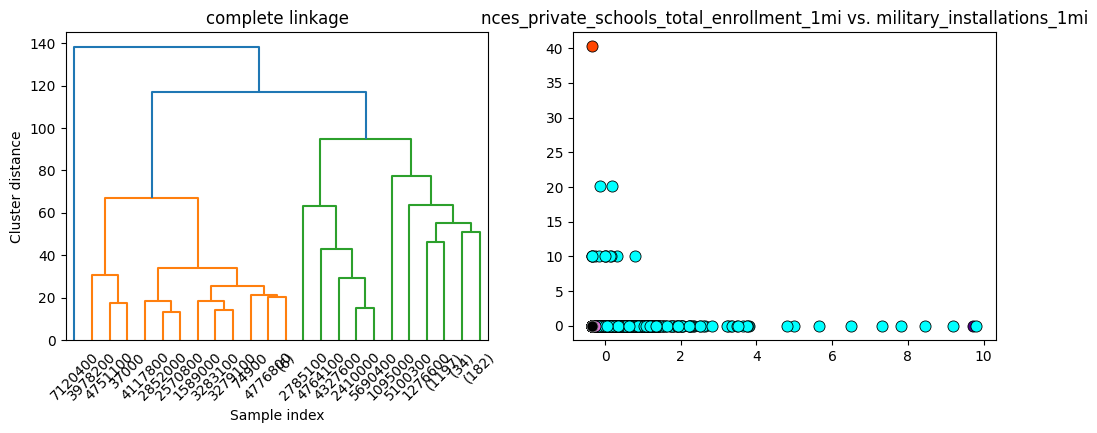

In [40]:
plot_dendrogram_clusters(
    train_df, 
    linkage_array, 
    hier_labels, 
    p=6, 
    linkage_type='complete', 
    axis_0="nces_private_schools_total_enrollment_1mi",
    axis_1="military_installations_1mi",
    title="nces_private_schools_total_enrollment_1mi vs. military_installations_1mi"
)

In [41]:
result_df['complete label'] = hier_labels 

In [42]:
unique, counts = np.unique(hier_labels, return_counts=True)
dict(zip(unique, counts))

{1: 3, 2: 14, 3: 4, 4: 1, 5: 1414, 6: 1, 7: 1, 8: 1}

---
### complete linkage with reduced data


In [43]:
reduced_linkage_array = complete(reduced_train)
reduced_hier_labels = fcluster(reduced_linkage_array, 10, criterion="maxclust") 

In [44]:
result_df['complet with reduced'] = reduced_hier_labels

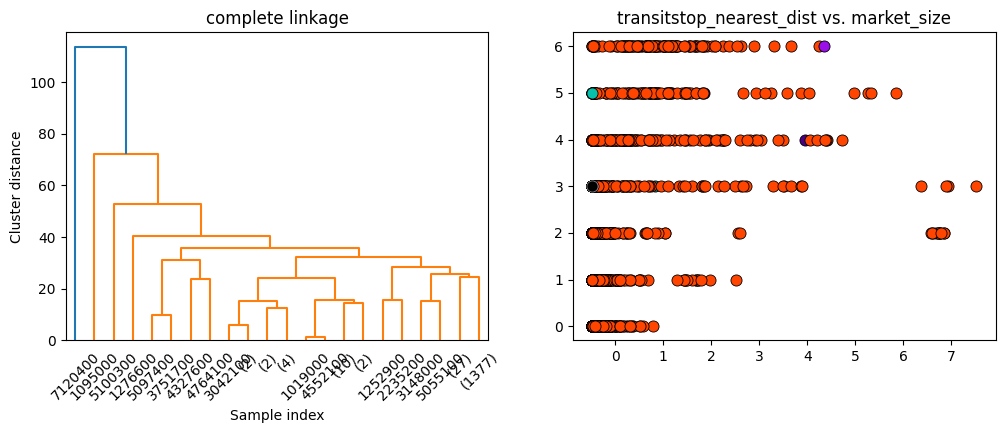

In [45]:
# market_size                                  4.254747
# emp_mining_p_ta                              3.865497
# emp_arts_entertainment_p_ta                  3.872087
# transitstop_nearest_dist                     3.363647
plot_dendrogram_clusters(
    reduced_train, 
    reduced_linkage_array, 
    reduced_hier_labels, 
    p=8, 
    linkage_type='complete', 
    axis_0="transitstop_nearest_dist",
    axis_1="market_size",
    title="transitstop_nearest_dist vs. market_size"
)

In [46]:
unique, counts = np.unique(reduced_hier_labels, return_counts=True)
dict(zip(unique, counts))

{1: 2, 2: 2, 3: 23, 4: 2, 5: 2, 6: 1404, 7: 1, 8: 1, 9: 1, 10: 1}

---
### complete linkage with PCA reduced data (1 layer)

In [47]:
pca_train = pca.transform(train_df)
linkage_arra_pca = complete(pca_train)
hier_labels_pca = fcluster(linkage_arra_pca, 10, criterion="maxclust") 

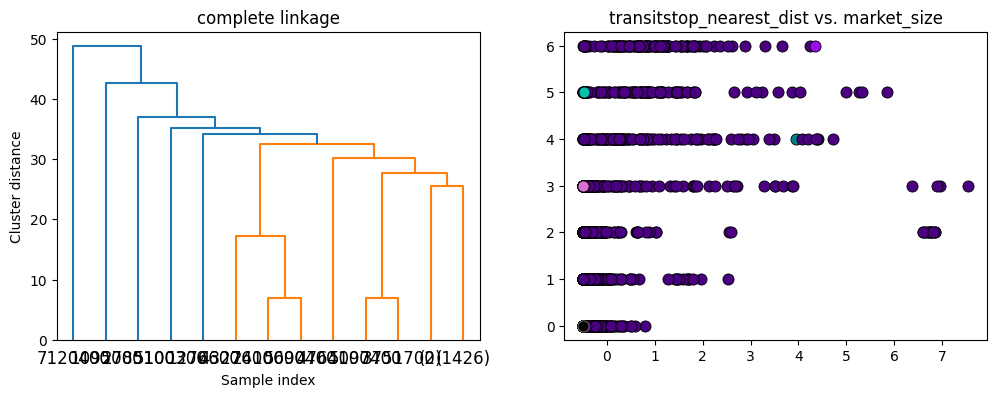

In [48]:
# market_size                                  4.254747
# emp_mining_p_ta                              3.865497
# emp_arts_entertainment_p_ta                  3.872087
# transitstop_nearest_dist                     3.363647
plot_dendrogram_clusters(
    train_df, 
    linkage_arra_pca, 
    hier_labels_pca, 
    p=8, 
    linkage_type='complete', 
    axis_0="transitstop_nearest_dist",
    axis_1="market_size",
    title="transitstop_nearest_dist vs. market_size"
)

In [49]:
result_df['complete with PCA'] = hier_labels_pca

In [50]:
unique, counts = np.unique(hier_labels_pca, return_counts=True)
dict(zip(unique, counts))

{1: 3, 2: 2, 3: 2, 4: 1426, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1}

In [51]:
result_df

,complete label,complet with reduced,complete with PCA
store,,,
5386700,5,6,4
2230200,5,6,4
4931100,5,6,4
2495200,5,6,4
2305300,5,6,4
...,...,...,...
2401900,5,6,4
5048900,5,6,4
1024900,5,6,4
